<a href="https://colab.research.google.com/github/HemendraSridhar/NLP/blob/main/NLP_Sentiment_Analysis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello!, Welcome to my NLP+Finance Project.

This is my Financial Sentiment Analysis Model that classifies financial text as positive, negative or neutral.

In [2]:
#Importing all the required modules
import tensorflow as tf
!pip install transformers
import os
import gdown
import torch
import numpy as np
import seaborn as sns
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn import metrics

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

%matplotlib inline
from google.colab import userdata

# gdown.download('drivelink1', 'finance_train.csv', True)
# gdown.download('drivelink2', 'finance_test.csv', True)

testurl = userdata.get('financetest_csvfile')
trainurl = userdata.get('financetrain_csvfile')

!wget "$testurl" -O finance_test.csv
!wget "$trainurl" -O finance_train.csv



def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(7,6))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

--2026-01-14 19:15:34--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29264 (29K) [application/vnd.ms-excel]
Saving to: ‘finance_test.csv’

finance_test.csv    100%[===================>]  28.58K  --.-KB/s    in 0.006s  

2026-01-14 19:15:35 (4.73 MB/s) - ‘finance_test.csv’ saved [29264/29264]

--2026-01-14 19:15:35--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis

In [3]:
df_train = get_finance_train()
df_test = get_finance_test()
sentences = df_train['Sentence'].values
labels = df_train['Label'].values

In [4]:
#Tokenization and Formatting
#Creating the tokens
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)
print("Number of unique tokens in the BERT model: ", tokenizer.vocab_size)

#Text formatting adding [CLS] and [SEP], Padding and truncating and then adding an attention mask
sentences_with_special_tokens = []
for sentence in sentences:
  new_sentence = "[CLS] " + sentence + " [SEP]"
  sentences_with_special_tokens.append(new_sentence)

#Tokenizing
tokenized_texts = []
for sentence in sentences_with_special_tokens:
  tokenized_sentence = tokenizer.tokenize(sentence)
  tokenized_texts.append(tokenized_sentence)

#Mapping tokens to their indexes
input_ids = []
for text in tokenized_texts:
  new_list = tokenizer.convert_tokens_to_ids(text)
  input_ids.append(new_list)

#Padding to a length of 128
input_ids = pad_sequences(input_ids,maxlen=128,dtype="long",truncating="post",padding="post")

#Adding attention masks
attention_masks = []
for sequence in input_ids:
  mask=[]
  for i in sequence:
    if i>0:
      mask.append(1.0)
    else:
      mask.append(0.0)
  attention_masks.append(mask)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Number of unique tokens in the BERT model:  30522


In [5]:
#Splitting Data into Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(input_ids,labels,test_size=0.15,random_state=RND_SEED)
#Splitting attention masks
train_masks, validation_masks, _, _ = train_test_split(attention_masks,input_ids,test_size=0.15,random_state=RND_SEED)

In [6]:
#Converting data into tensors and creating dataloaders
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data);
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data);
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

In [7]:
#Finetuning model using BertForSequenceClassificationModel
model = BertForSequenceClassification.from_pretrained( "bert-base-uncased", num_labels = 3, output_attentions = False, output_hidden_states = False);

#Specifying GPU usage for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

if tf.test.gpu_device_name() == '/device:GPU:0':
  model.cuda();

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
#Initializing hyperparameters - learning rate and number of epochs
optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)
epochs = 4

#TRAINING THE MODEL
total_steps = len(train_dataloader) * epochs

#Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(train_dataloader) * epochs

#Creating the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = total_steps)

training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    #Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    #Resetting the total loss for  epoch
    total_train_loss = 0
    #Putting the model into training mode
    model.train()
    for step, batch in enumerate(train_dataloader):
        #Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            #Reporting progress
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        #STEP 1 and 2: Unpacking this training batch from our dataloader
        # While unpacking the batch, also copying each tensor to the GPU using the
        # `to` method.`batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #STEP 3
        # Clearing any previously calculated gradients before performing a backward pass
        model.zero_grad()

        #STEP 4
        # Performing a forward pass (also evaluating the model on this training batch)
        # It returns the loss as the labels are provided
        # the "logits" are the model outputs prior to activation
        outputs = model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask,labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        #adding the training loss over all of the batches to calculate the average loss at the end. `loss` is a Tensor containing a
        #single value; the .item() function only returns the Python value from the tensor
        total_train_loss += loss.item()

        #STEP 5
        # Performing a backward pass to calculate the gradients
        loss.backward()
        # Clipping the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #STEP 6
        # Updating parameters and taking a step using the computed gradient
        optimizer.step()
        # Updating the learning rate.
        scheduler.step()

    #Calculating the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    print("Average training loss: {0:.2f}".format(avg_train_loss))

    #Validation
    #After the completion of each training epoch, we measure the performance on the validation set.
    print("Evaluating on Validation Set")
    #Putting the model in evaluation mode
    model.eval()
    #Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    #Evaluate data for one epoch
    for batch in validation_dataloader:
        #Step 1 and Step 2
        #Unpacking this validation batch from our dataloader
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Telling pytorch not to construct the compute graph during the forward pass, since its only needed for backpropogation
        with torch.no_grad():

            #Forward pass, calculate logit(here they are outputs) predictions.
            #values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        #adding the validation loss.
        total_eval_loss += loss.item()

        #Moving logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Calculating accuracy for this batch of test sentences, and add it over all batches
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    #Final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    #Calculating the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("Validation Loss: {0:.2f}".format(avg_val_loss))

    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)

    #Record all statistics from this epoch.
    training_stats.append({'epoch': epoch_i + 1, 'Training Loss': avg_train_loss, 'Valid. Loss': avg_val_loss, 'Valid. Accur.': avg_val_accuracy})

print("Training complete!")

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
Average training loss: 0.67
Evaluating on Validation Set
Validation Accuracy: 0.92
Validation Loss: 0.33
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
Average training loss: 0.19
Evaluating on Validation Set
Validation Accuracy: 0.96
Validation Loss: 0.14
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
Average training loss: 0.06
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.12
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
Average training loss: 0.03
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.12
Training complete!


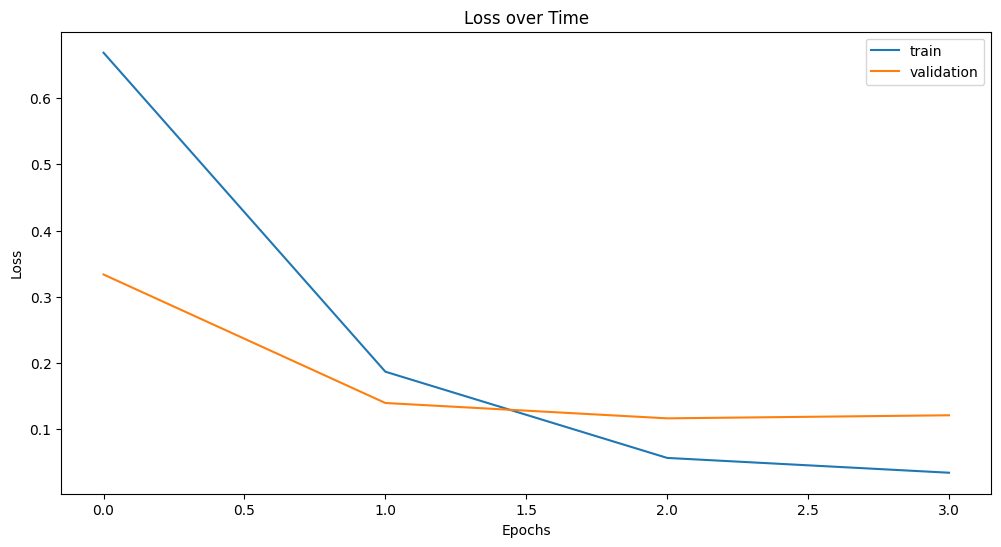

In [9]:
#Plotting the losses
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label='train')
plt.plot(validation_loss, label='validation')

plt.legend()
plt.show()

In [10]:
#Evaluating Test Set Accuracy
test_sentences = df_test.Sentence.values
test_labels = df_test.Label.values

In [11]:
#Formatting Test input data
test_input_ids, test_attention_masks = [], []

#Adding Special Tokens ([CLS] and [SEP])
formatted_sentences = []
for sentence in test_sentences:
  new_sent = "[CLS] " + sentence + " [SEP]"
  formatted_sentences.append(new_sent)
test_sentences = formatted_sentences

#Tokenizing sentences
tokenized_test_sentences = []
for sent in test_sentences:
  tokens = tokenizer.tokenize(sent)
  tokenized_test_sentences.append(tokens)

#Encoding Tokens to Word IDs
test_input_ids = []
for txt in tokenized_test_sentences:
   ids = tokenizer.convert_tokens_to_ids(txt)
   test_input_ids.append(ids)

#Padding the inputs
test_input_ids = pad_sequences(test_input_ids, maxlen=128, dtype="long", truncating="post", padding="post")

#Creating Attention Masks
for sequence in test_input_ids:
  mask = []
  for i in sequence:
    if i>0:
      mask.append(1.0)
    else:
      mask.append(0.0)
  test_attention_masks.append(mask)

In [12]:
#Converting Data to Tensors and create Dataloaders
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Predicting labels for 227 test sentences...
Test Accuracy: 97.80%
Plotting the Confusion Matrix


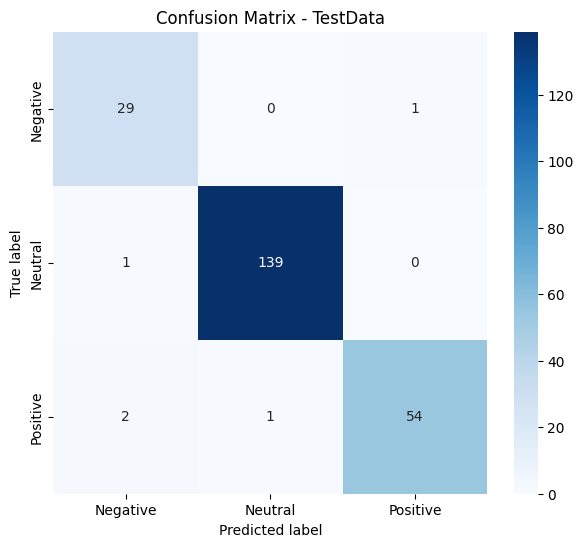

In [13]:
#Evaluating Test Set Accuracy

#Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

#Putting model in evaluation mode
model.eval()

#Tracking variables
predictions , true_labels = [], []

#Prediction
for batch in prediction_dataloader:
  #Adding batch to GPU
  batch = tuple(t.to(device) for t in batch)

  #Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      #Forward pass, calculating logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs[0]

  #Moving logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  #Storing predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

#Final tracking variables
y_logits, y_true, y_preds = [], [], []

#Appending logit predictions
for chunk in predictions:
  for logits in chunk:
    y_logits.append(logits)

#Appending true labels
for chunk in true_labels:
  for label in chunk:
    y_true.append(label)

#Appending real predictions
for logits in y_logits:
  y_preds.append(np.argmax(logits))

print('Test Accuracy: {:.2%}'.format(metrics.accuracy_score(y_preds,y_true)))
plot_confusion_matrix(y_true,y_preds)

In [14]:
#THANK YOU FOR READING!